In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections #---> Library for operating with dictionaries
import random #---> Library for generating random numbers/distributions
import numpy as np #---> Library for efficiently operating with arrays/matrices/vectors
from pylab import rcParams #---> 
from operator import itemgetter 
 
import powerlaw
import seaborn as sns
import matplotlib.colors as mcolors
from itertools import count
import matplotlib.cm as cm
import community
import igraph
from collections import Counter
import matplotlib as mpl
import matplotlib.patches as patches
import random
import time

In [2]:
#Load the Network in a graph G
Gx = nx.read_edgelist('infect-dublin.edges.txt', nodetype=int, create_using=nx.Graph(),data=(('weight',float),))

SIR Model.
It has been discovered that the all the infected after a given recovery time became immune. If a node is immune
and it is in contact with the infected node it does not became infected, and it will not spread the infection!

Define the function SIR_model() that inputs:

• G (a Network as networkx)

• initial_infected (nodes that are infected at time=0 as list of nodes ID)

• beta (trasmission probability as float)

• t_simulation (simulation iteration time as int)

• recovery_time (the number of days needed for the recovery.)

• nodes that are vaccinated as list of nodes ID.


Output: a dictionary that contains the nodes status at each time steps. In this case the status can be:

• ’S’ as susceptible.

• ’I’ as Infected.

• ’R’ as Recovered.

Using the network Gx and beta=0.005, t_simulation=300, initial_infected=(list of 3 random nodes),
recovery_time=15, plot the number of users in each status at each simulation time step.

In [3]:
def SIR_model(Gx,beta,t_simulation,initial_infecteds,recovery_time,vaccinated):
    
    #add default status 'S' and counter to -1 for all nodes. 
    #Counter is introduced to keep track of the days of infection
    nx.set_node_attributes(Gx, 'S', "Status")
    nx.set_node_attributes(Gx, -1, "counter")
    Gx_node=list(Gx.nodes)
    Gx_node.sort()

    #creating an Infection history of all nodes from t=0 to 300
    Infection_history=np.zeros((len(Gx_node),t_simulation+1))

    #update the status of initial infections
    for i in initial_infecteds:
        Gx.nodes[i]['Status'] = 'I'
        Gx.nodes[i]['counter'] = 0
        Infection_history[i-1][0]=1       
    #update the status of vaccinated nodes
    for i in vaccinated:
        Gx.nodes[i]['Status'] = 'R'
        Gx.nodes[i]['counter'] = 15
        for t in range(0,(t_simulation+1)):
            Infection_history[i-1][t]=-1
    
    for t in range(1,(t_simulation+1)):
        
        i_list=[]
        Infection_list=[x for x,y in Gx.nodes(data=True) if y['Status']=='I']
        
        #for each infected node
        for i in Infection_list:
                        
            #getting the day count of infection
            c=Gx.nodes[i]['counter']
            
            c+=1
            
            #if days less than recovery time it can infect its neighbors else it becomes recovered and is removed
            if c<recovery_time:
                Infection_history[i-1][t]=1
                Gx.nodes[i]['counter'] = c
                
                #find the neighbours of the infected node
                neighbors=list(nx.all_neighbors(Gx,i))
                
                for n in neighbors:
                   
                    if Gx.nodes[n]['Status'] == 'S':
                        #infecting the neighbors with a probability of beta
                        prob=np.random.uniform(0,1)
                        if prob<=beta:
                            Gx.nodes[n]['Status'] = 'I'
                            Gx.nodes[n]['counter'] = 0
                            i_list.append(n)
                    else:
                        continue
            else:
                Gx.nodes[i]['Status'] = 'R'
                Gx.nodes[i]['counter'] = c
                for k in range(t,t_simulation+1):
                    Infection_history[i-1][k]=-1
        
        #updating the history with the new infected nodes 
        for j in i_list:
            Infection_history[j-1][t]=1
  
    #creating a dictionary of nodes status at each timestamp
    l=Infection_history.tolist() 
    l1=[]
    for i in range(len(l)):
        l2=[]
        for j in range(len(l[i])):
            if l[i][j]==0:
                l2.append('S')
            if l[i][j]==1:
                l2.append('I')
            if l[i][j]==-1:
                l2.append('R')
        l1.append(l2)
        
    d=zip(Gx_node, l1)
    dic=dict(d)

    return dic

def plot_SIR(x_n,s_n,r_n,t_simulation):
    I=x_n.tolist()
    S=s_n.tolist()
    R=r_n.tolist()
    
    X=[i for i in range(t_simulation+1)]
    plt.figure(figsize = (40,30))
    plt.plot(X,I,'go',linestyle='solid')
    plt.plot(X,S,'ro',linestyle='solid')
    plt.plot(X,R,'bo',linestyle='solid')
    plt.xlabel("Simulation time",fontsize=25)  # add X-axis label
    plt.ylabel("No. of users",fontsize=25)  # add Y-axis label
    plt.title("SIR model",fontsize=35)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.legend(["Infected", "Susceptible","Recovered"],fontsize=20)
    plt.show()

Run the model

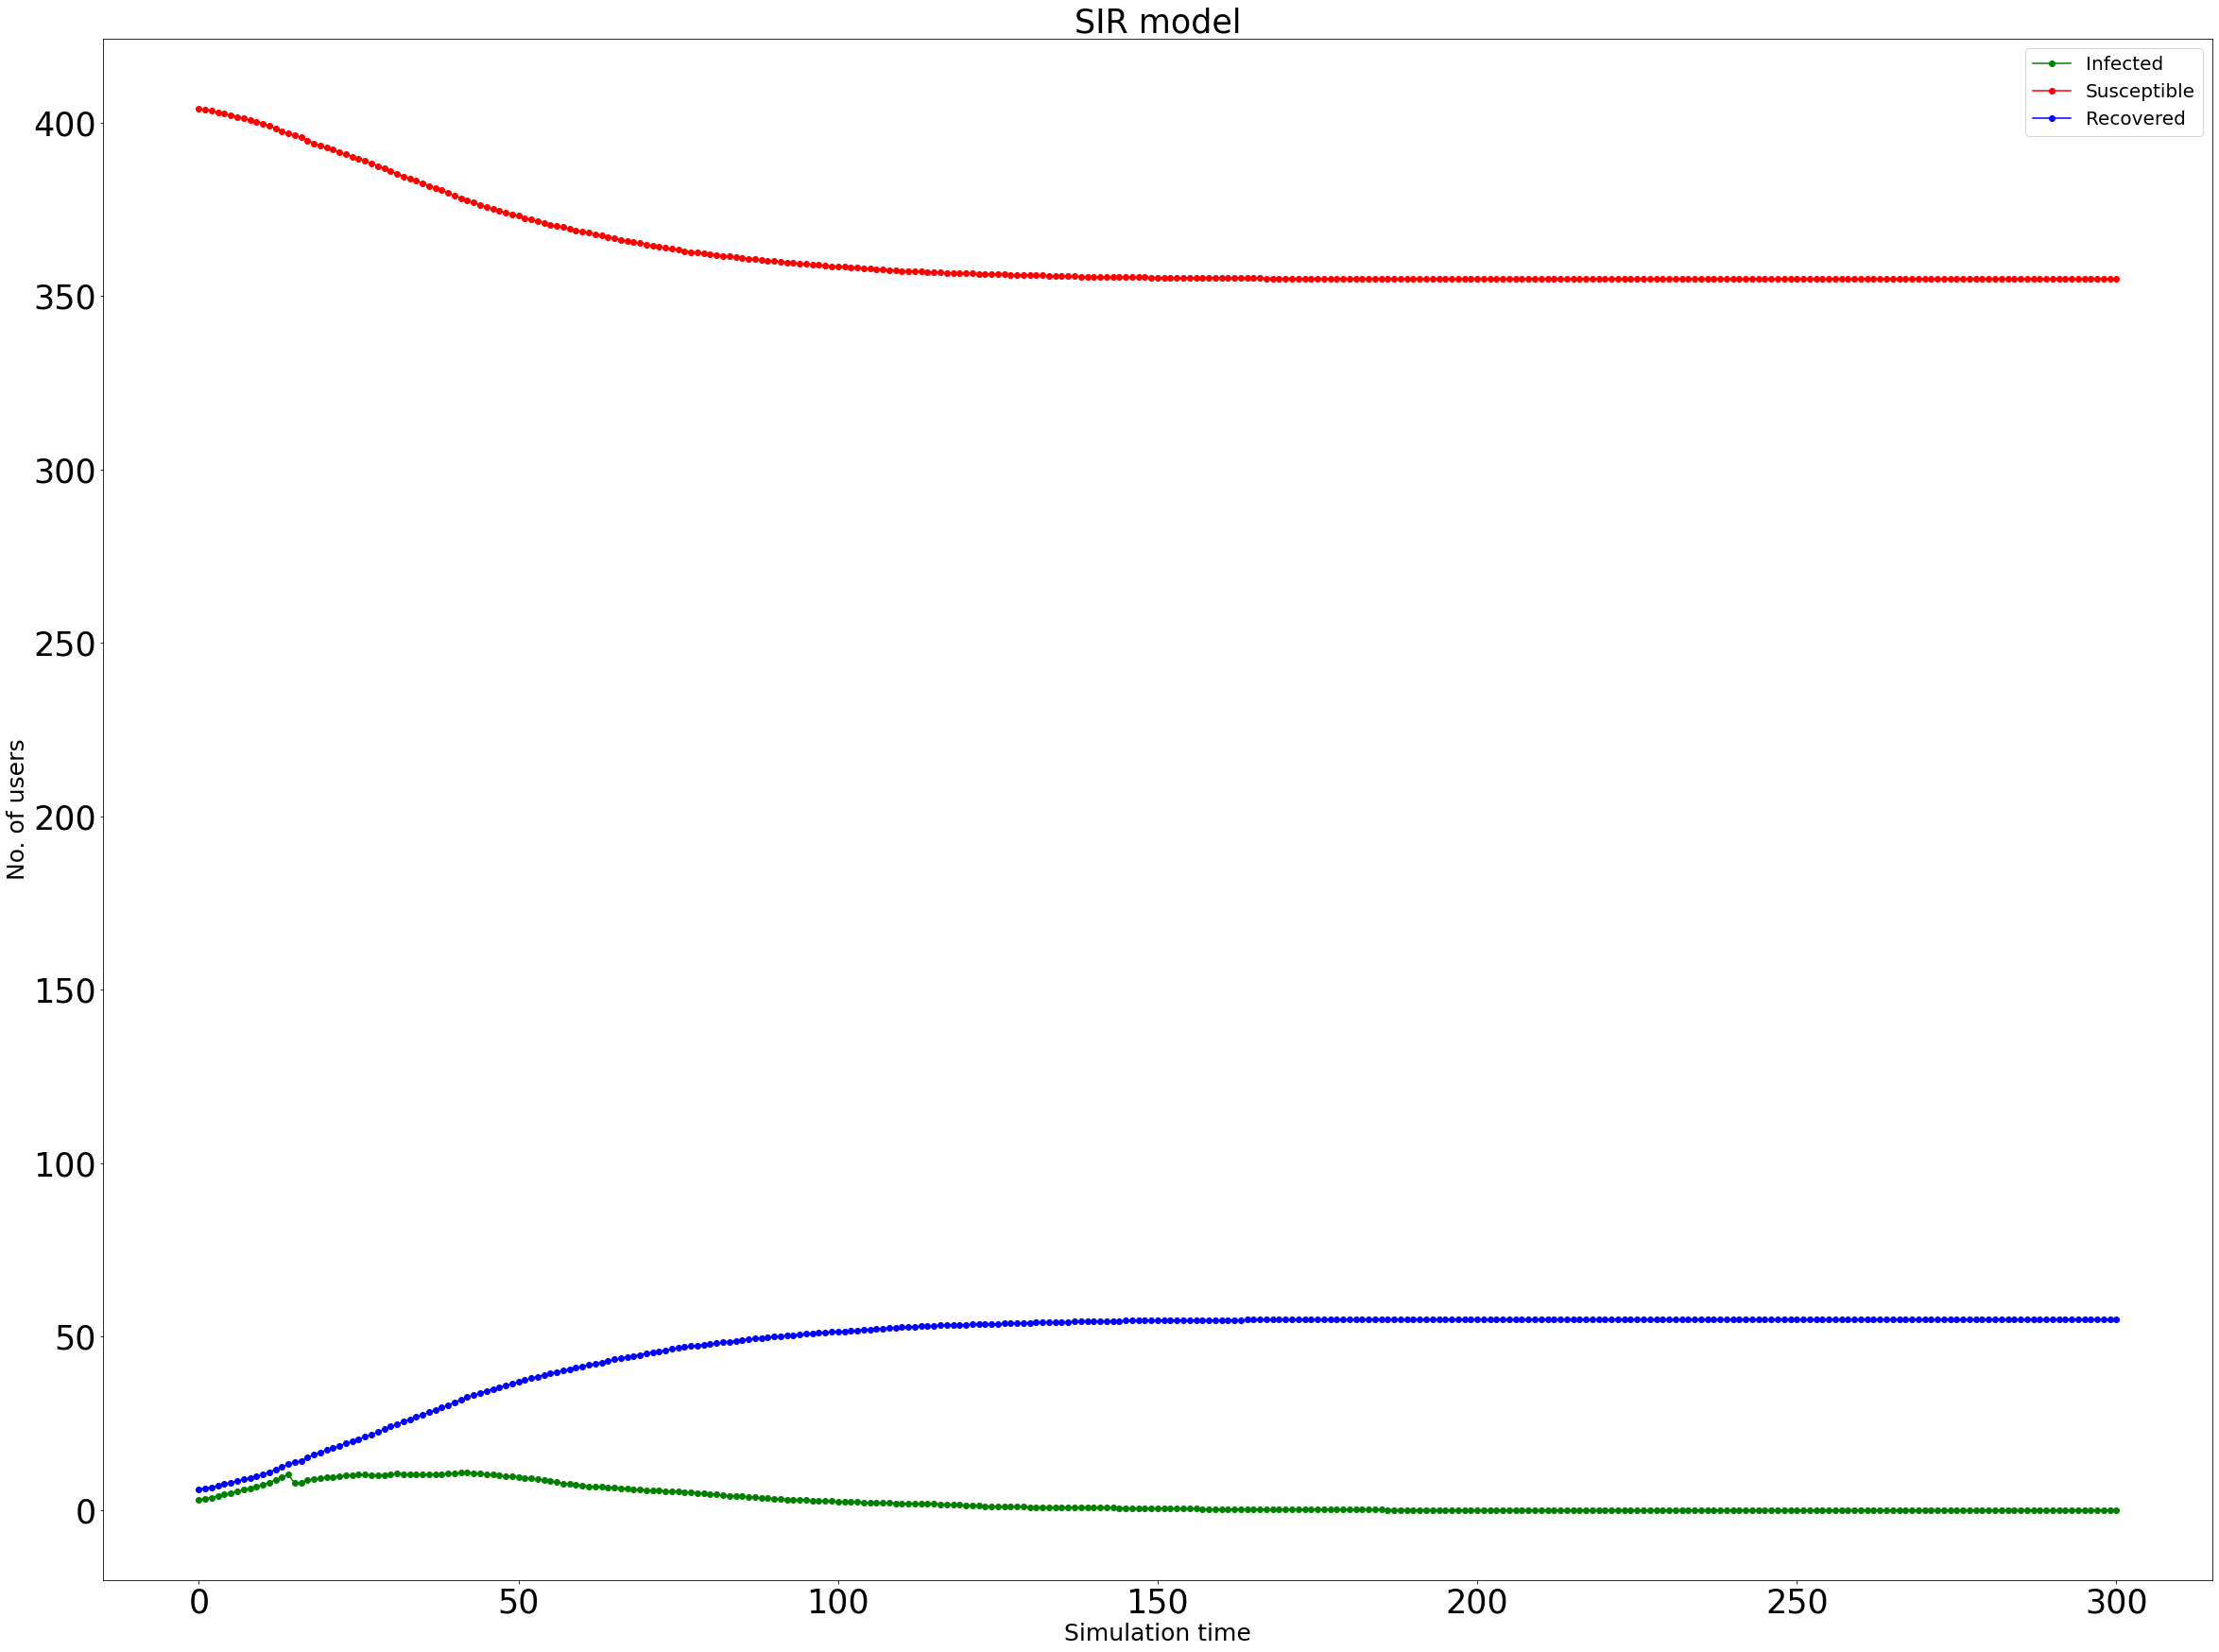

--- 32.7258939743042 seconds ---


In [4]:
beta=0.005
t_simulation=300
initial_infecteds=[100,200,300]  
recovery_time=15
vaccinated=[20,60,101]
x_n=[]
s_n=[]
r_n=[]

start = time.time()

for t in range(100):

    Infections_t=SIR_model(Gx,beta,t_simulation,initial_infecteds,recovery_time,vaccinated)
    Infections_val=list(Infections_t.values())
    l1_x=[]
    l1_s=[]
    l1_r=[]
    for j in range(t_simulation+1):
        x_sum=0
        s_sum=0
        r_sum=0
        for i in range(len(Infections_val)):
            if Infections_val[i][j]=='I':
                x_sum+=1
            if Infections_val[i][j]=='S':
                s_sum+=1
            else:
                r_sum+=1
        l1_x.append(x_sum)
        l1_s.append(s_sum)
        l1_r.append(r_sum)
    x_n.append(l1_x)
    s_n.append(l1_s)
    r_n.append(l1_r)

x_n=np.array(x_n)
s_n=np.array(s_n)
r_n=np.array(r_n)

#getting the mean for each day for 100 simulations
x_t1=x_n.mean(axis=0)
s_t1=s_n.mean(axis=0)
r_t1=r_n.mean(axis=0)
#plotting the SIR model for 100 simulations
plot_SIR(x_t1,s_t1,r_t1,t_simulation)
            
            

print("--- %s seconds ---" % (time.time() - start))

As depicted in the above plot the infection doesn't spread fast due to the beta=0.005 being too low, hence the transmissibility is very low.

Pictorial representation of the simulation

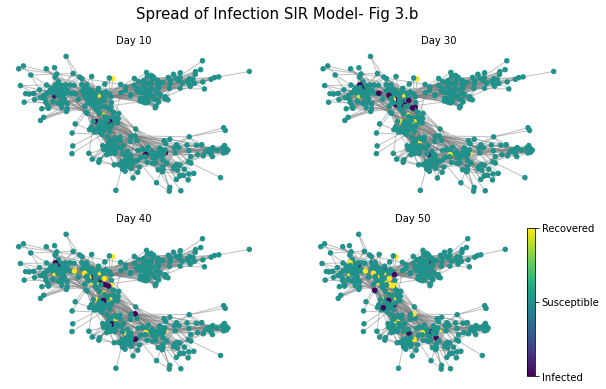

In [5]:
#Q 3b Pictorial representation of the simulation
def plot_nodestatus(Gx,node_list,day10,day30,day40,day50):
    
    plt.rcParams["figure.figsize"] = (10,6)
    fig, axes = plt.subplots(nrows=2, ncols=2)
    
    ax = axes.flatten()
    
    
    pos=nx.spring_layout(Gx)
    edge_list=Gx.edges
    norm = mcolors.Normalize(vmin = 0, vmax = 2)
    smp = cm.ScalarMappable(norm=norm, cmap = cm.viridis)
    cbar = plt.colorbar(smp, )
    cbar.set_ticks(range(0, 3))
    cbar.set_ticklabels(["Infected","Susceptible","Recovered"])
    plt.axis('off')
    #plot the 4 chosen days
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day10, node_size = 20,ax=ax[0])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[0])
   
    ax[0].set_title("Day 10",fontsize=10)
    ax[0].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day30, node_size = 20,ax=ax[1])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[1])
    ax[1].set_title("Day 30",fontsize=10)
    ax[1].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day40, node_size = 20,ax=ax[2])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[2])
    ax[2].set_title("Day 40",fontsize=10)
    ax[2].set_axis_off()
    
    nx.draw_networkx_nodes(Gx, pos, nodelist = node_list, node_color = day50, node_size = 20,ax=ax[3])
    nx.draw_networkx_edges(Gx,pos,edgelist=edge_list,edge_color='gray',width=1,alpha=0.5,ax=ax[3])
    ax[3].set_title("Day 50",fontsize=10)
    ax[3].set_axis_off()
    
    fig.suptitle("Spread of Infection SIR Model- Fig 3.b",fontsize=15)
    
    plt.show()
    
    
#get the staus of the nodes for chosen days
node_list=list(Infections_t.keys())
infection_hist=list(Infections_t.values())
infection_hist=np.array(infection_hist)

day10=infection_hist[:,10:11].tolist()
day30=infection_hist[:,30:31].tolist()
day40=infection_hist[:,40:41].tolist()
day50=infection_hist[:,50:51].tolist()

day10=[item for sublist in day10 for item in sublist]
day30=[item for sublist in day30 for item in sublist]

day40=[item for sublist in day40 for item in sublist]
day50=[item for sublist in day50 for item in sublist]


color10=[]
color30=[]
color40=[]
color50=[]
#Color the nodes based on the status for each day

for i in range(len(day10)):
    if day10[i]=='I':
        color10.append(0)
        
    if day10[i]=='S':
        color10.append(1)
        
    if day10[i]=='R':
        color10.append(2)
        
        
for i in range(len(day30)):
    if day30[i]=='I':
        color30.append(0)
        
    if day30[i]=='S':
        color30.append(1)
        
    if day30[i]=='R':
        color30.append(2)
        
        
for i in range(len(day40)):
    if day40[i]=='I':
        color40.append(0)
        
    if day40[i]=='S':
        color40.append(1)
        
    if day40[i]=='R':
        color40.append(2)
        
        
for i in range(len(day50)):
    if day50[i]=='I':
        color50.append(0)
    if day50[i]=='S':
        color50.append(1)
    if day50[i]=='R':
        color50.append(2)


    
plot_nodestatus(Gx,node_list,color10,color30,color40,color50)

Above simulation depicts the spread of the infection in SIR model